# MNIST digits classification with TensorFlow

<img src="images/mnist_sample.png" style="width:30%">

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
%matplotlib inline
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print("We're using TF", tf.__version__)

Instructions for updating:
non-resource variables are not supported in the long term
We're using TF 2.1.0


In [2]:
from Utils import matplotlib_utils
from importlib import reload
reload(matplotlib_utils)
from Utils import keras_utils
from Utils.keras_utils import reset_tf_session

# Look at the data

In this task we have 50000 28x28 images of digits from 0 to 9.
We will train a classifier on this data.

In [3]:
from Utils import preprocessed_mnist
X_train, y_train, X_val, y_val, X_test, y_test = preprocessed_mnist.laod_dataset()

Using TensorFlow backend.


(60000, 28, 28) (10000, 28, 28) (60000,) (10000,)


X_train [shape (50000, 28, 28)] sample patch:
 [[0.         0.29803922 0.96470588 0.98823529 0.43921569]
 [0.         0.33333333 0.98823529 0.90196078 0.09803922]
 [0.         0.33333333 0.98823529 0.8745098  0.        ]
 [0.         0.33333333 0.98823529 0.56862745 0.        ]
 [0.         0.3372549  0.99215686 0.88235294 0.        ]]
A closeup of a sample patch:


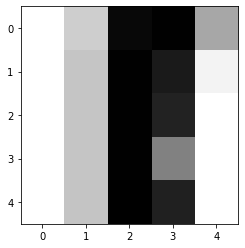

And the whole sample:


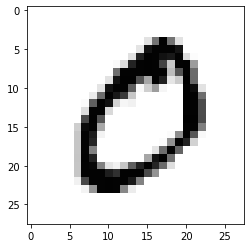

y_train [shape (50000,)] 10 samples:
 [5 0 4 1 9 2 1 3 1 4]


In [4]:
# X contains rgb values divided by 255
print("X_train [shape %s] sample patch:\n" % (str(X_train.shape)), X_train[1, 15:20, 5:10])
print("A closeup of a sample patch:")
plt.imshow(X_train[1, 15:20, 5:10], cmap="Greys")
plt.show()
print("And the whole sample:")
plt.imshow(X_train[1], cmap="Greys")
plt.show()
print("y_train [shape %s] 10 samples:\n" % (str(y_train.shape)), y_train[:10])

# Linear model

Our task is to train a linear classifier $\vec{x} \rightarrow y$ with SGD using TensorFlow.

We will need to calculate a logit (a linear transformation) $z_k$ for each class: 
$$z_k = \vec{x} \cdot \vec{w_k} + b_k \quad k = 0..9$$

And transform logits $z_k$ to valid probabilities $p_k$ with softmax: 
$$p_k = \frac{e^{z_k}}{\sum_{i=0}^{9}{e^{z_i}}} \quad k = 0..9$$

We will use a cross-entropy loss to train our multi-class classifier:
$$\text{cross-entropy}(y, p) = -\sum_{k=0}^{9}{\log(p_k)[y = k]}$$ 

where 
$$
[x]=\begin{cases}
       1, \quad \text{if $x$ is true} \\
       0, \quad \text{otherwise}
    \end{cases}
$$

Cross-entropy minimization pushes $p_k$ close to 1 when $y = k$, which is what we want.

Here's the plan:
* Flatten the images (28x28 -> 784) with `X_train.reshape((X_train.shape[0], -1))` to simplify our linear model implementation
* Use a matrix placeholder for flattened `X_train`
* Convert `y_train` to one-hot encoded vectors that are needed for cross-entropy
* Use a shared variable `W` for all weights (a column $\vec{w_k}$ per class) and `b` for all biases.
* Aim for ~0.93 validation accuracy

In [5]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
print(X_train_flat.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
print(X_val_flat.shape)

(50000, 784)
(10000, 784)


In [6]:
import keras

y_train_oh = keras.utils.to_categorical(y_train, 10)
y_val_oh = keras.utils.to_categorical(y_val, 10)

print(y_train_oh.shape)
print(y_train_oh[:3], y_train[:3])

(50000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


In [7]:
# run this again if you remake your graph
s = reset_tf_session()

In [8]:
# Model parameters: W and b
W = tf.get_variable(name='W', shape=(X_train_flat.shape[1], y_train_oh.shape[1]), dtype=tf.float32)### YOUR CODE HERE ### tf.get_variable(...) with shape[0] = 784
b = tf.get_variable(name='b', shape=(y_train_oh.shape[1], ), dtype=tf.float32)### YOUR CODE HERE ### tf.get_variable(...)

In [9]:
# Placeholders for the input data
input_X = tf.placeholder('float32', shape=(None, X_train_flat.shape[1]), name='input_x')### YOUR CODE HERE ### tf.placeholder(...) for flat X with shape[0] = None for any batch size
input_y = tf.placeholder('float32', shape=(None, y_train_oh.shape[1]), name='input_y')### YOUR CODE HERE ### tf.placeholder(...) for one-hot encoded true labels

In [10]:
# Compute predictions
logits = input_X @ W + b### YOUR CODE HERE ### logits for input_X, resulting shape should be [input_X.shape[0], 10]
probas = tf.nn.softmax(logits)### YOUR CODE HERE ### apply tf.nn.softmax to logits
classes = tf.argmax(probas, 1)### YOUR CODE HERE ### apply tf.argmax to find a class index with highest probability

# Loss should be a scalar number: average loss over all the objects with tf.reduce_mean().
# Use tf.nn.softmax_cross_entropy_with_logits on top of one-hot encoded input_y and logits.
# It is identical to calculating cross-entropy on top of probas, but is more numerically friendly (read the docs).
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_y, logits=logits))### YOUR CODE HERE ### cross-entropy loss

# Use a default tf.train.AdamOptimizer to get an SGD step
step = tf.train.AdamOptimizer(learning_rate=0.01).minimize(loss)### YOUR CODE HERE ### optimizer step that minimizes the loss

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
print(logits.shape)

(?, 10)


In [12]:
s.run(tf.global_variables_initializer())

BATCH_SIZE = 512
EPOCHS = 40

# for logging the progress right here in Jupyter (for those who don't have TensorBoard)
simpleTrainingCurves = matplotlib_utils.SimpleTrainingCurves("cross-entropy", "accuracy")

for epoch in range(EPOCHS):  # we finish an epoch when we've looked at all training samples
    
    batch_losses = []
    for batch_start in range(0, X_train_flat.shape[0], BATCH_SIZE):  # data is already shuffled
        _, batch_loss = s.run([step, loss], {input_X: X_train_flat[batch_start:batch_start+BATCH_SIZE], 
                                             input_y: y_train_oh[batch_start:batch_start+BATCH_SIZE]})
        # collect batch losses, this is almost free as we need a forward pass for backprop anyway
        batch_losses.append(batch_loss)

    train_loss = np.mean(batch_losses)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})  # this part is usually small
    train_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))  # this is slow and usually skipped
    valid_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))  
    simpleTrainingCurves.add(train_loss, val_loss, train_accuracy, valid_accuracy)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAEgCAYAAADSVRDhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOzdeXxM1/vA8c/IRCKykAgSYwlRISsJodZS%2B1JLiqqldt8v36ILWl10pS3VFqV2WkSrVUtV7dWfLZaiEUuQRDYRqUQWiWRyfn/cuqQSjSIRnvfrdV%2BZuffce8%2BZxIxnzjnPMSilFEIIIYQQQgghHrhSxV0BIYQQQgghhHhcSAAmhBBCCCGEEEVEAjAhhBBCCCGEKCISgAkhhBBCCCFEEZEATAghhBBCCCGKiARgQgghhBBCCFFEJAATQgghhBBCiCIiAZgQQgghhBBCFBEJwIQQQgghhBCiiEgAJoQQQgghhBBFRAIwIYQQQgghhCgiEoAJIYQQQgghRBGRAEwIIYQQQgghiogEYEIIIYQQQghRRCQAE0IIIYQQQogiIgGYEEIIIYQQQhQRCcCEEEIIIYQQoohIACaEEEIIIYQQRUQCMCGEEEIIIYQoIhKACSHumsFg4OzZs8VdDSGEEEKIEkcCMCEeMjk5OcVdhXv2KLRBCCFKIqUUubm5xV0NIcQdSAAmRBGKjo6mZ8%2BeODs74%2BTkxJgxY1i6dClNmzZl/PjxODo6MmXKFHJzc3n//fepXr06FStWZODAgaSkpACQmZlJ//79cXJyoly5cjRs2JCEhAQAli5dSs2aNbGzs8PNzY0VK1YUWJdTp07Rtm1bHB0dqVOnDt9%2B%2B61%2B7IUXXmD06NF07twZOzs7AgMDOXfuHAAtWrQAwNfXF1tbW1avXs2uXbswmUx89NFHVK5cmcGDBwOwYMEC3N3dcXR0pFu3bsTFxen3MBgMfPHFF9SsWZMKFSrw6quvkpubS1ZWFo6Ojvzxxx962UuXLlGmTBkSExPv029CCCEerGnTplGrVi3s7OyoV68ea9eu1Y8tWLCAunXr6seOHDkC5P8ZATBlyhT69%2B%2Bvnx8ZGYnBYNC/7GrVqhWTJ0%2BmadOm2NjYcP78eZYsWaLfo2bNmnz11Vd56rdu3Tr8/Pywt7enVq1abN68me%2B%2B%2Bw5/f/885WbMmEH37t0fyGskxGNLCSGKRE5OjvLx8VHjxo1TaWlp6tq1a%2Bq3335TS5YsURYWFuqLL75Q2dnZKiMjQy1atEjVqlVLnTt3TqWmpqoePXqo/v37K6WUmjdvnurSpYtKT09XOTk56tChQyolJUWlpaUpOzs7derUKaWUUnFxcSo0NDTfuqSlpSmTyaQWL16ssrOz1eHDh5WTk5NeftCgQap8%2BfLqwIEDKjs7W/Xr10/16dNHPx9Q4eHh%2BvOdO3cqCwsLNWHCBJWZmakyMjLU9u3blZOTkzp8%2BLDKzMxUY8aMUc2bN89zjVatWqmkpCQVFRWlateurRYsWKCUUuo///mPmjBhgl72s88%2BU126dLlPvwkhhHjwvv32WxUbG6vMZrMKDg5WNjY2Ki4uTn377bfK1dVVhYSEqNzcXBUeHq4iIyML/IxQSqm3335bPf/88/q1IyIiFKCys7OVUkq1bNlSVa1aVYWGhqrs7Gx1/fp1tXHjRnX27FmVm5urdu3apcqUKaMOHz6slFLqwIEDyt7eXm3ZskWZzWYVExOjTp48qTIzM1X58uVVWFiYfi8/Pz%2B1Zs2aInzlhHj0SQAmRBHZu3evqlChgv6BecOSJUtU1apV8%2Bxr3bq1mjNnjv781KlTymg0quzsbLVo0SLVpEkTdezYsTznpKWlKQcHB7VmzRqVkZFxx7oEBwerZs2a5dk3YsQINWXKFKWUFoANHTpUP/bTTz%2BpOnXq6M/zC8AsLS3VtWvX9H1DhgxRr776qv48NTVVGY1GFRERoV/j559/1o/PmTNHtW7dWiml1P79%2B5XJZFJms1kppZS/v79avXr1HdskhBAPM19fX/Xjjz%2Bqdu3aqc8%2B%2B%2By24wV9RihVuADszTffvOP9n3nmGf2%2BI0aMUOPGjcu33KhRo9Trr7%2BulFIqNDRUlStXTmVmZhaukUKIQpEhiEIUkejoaKpXr47RaLztWNWqVfM8j4uLo3r16vrz6tWrk5OTQ0JCAgMGDKB9%2B/b07dsXV1dXJkyYQHZ2NmXLlmX16tXMmzcPFxcXOnfuzKlTpwDw9PTE1tYWW1tbfvvtN6Kiojhw4ADlypXTtxUrVnDx4kX9npUrV9Yf29jYkJaWdsf2OTs7Y21tXWAbbG1tcXJyIjY2Nt92V69eXR%2BiGBgYSNmyZfn11185deoUZ8%2BepVu3bne8vxBCPEyWL1%2BOn5%2Bf/h4bGhrK5cuXiY6OplatWreVv9NnRGH8/XPk559/pnHjxjg6OlKuXDk2bdrE5cuX9XvlVweAQYMGsXLlSpRSfP311/Tu3RsrK6t/VSchRP4kABOiiFStWpULFy7km6DCYDDkee7q6kpUVJT%2B/MKFCxiNRipVqoSlpSVvv/02YWFh7N27l40bN7J8%2BXIA2rdvz9atW4mPj8fDw4Phw4cDcOLECdLS0khLS6N58%2BZUrVqVli1bkpycrG9paWnMnTv3X7fvn9qQnp5OUlISVapU0fdFR0fnaaOrq6v%2BfNCgQXzzzTd8/fXXBAUF5QnuhBDiYRYVFcXw4cOZPXs2SUlJJCcn4%2BXlhVKKqlWr6nNqb3Wnz4iyZcuSkZGhP7/1y7Ibbn0PzsrKolevXrzyyiskJCSQnJxMp06dUErp98qvDgCNGzemdOnS/Pbbb6xcuZIBAwbcdfuFEHcmAZgQRaRRo0a4uLgwadIk0tPTyczMZM%2BePfmWfe6555g5cyYRERGkpaXx%2Buuv06dPH4xGIzt37uSPP/7AbDZjb2%2BPpaUlFhYWJCQksH79etLT07GyssLW1hYLC4t8r9%2BlSxfOnDnD119/TXZ2NtnZ2Rw8eJCTJ08Wqi2VKlXi/PnzdyzTr18/lixZwtGjR8nKyuL1118nMDCQGjVq6GU%2B%2BeQTrly5QnR0NJ9//jl9%2BvTRjw0YMIC1a9fyzTffMHDgwELVSwghHgbp6ekYDAacnZ0BWLJkCaGhoQAMGzaM6dOnc/jwYZRSnD17lqioqDt%2BRvj5%2BbF7924uXLhASkoKU6dOveP9r1%2B/TlZWFs7OzhiNRn7%2B%2BWe2bNmiHx86dChLlixh%2B/bt5ObmEhsbq4%2BYABg4cCBjxozBaDTSrFmz%2B/3yCPHYkwBMiCJiYWHBhg0bOHv2LNWqVcNkMrF69ep8yw4ZMoQBAwbQokUL3NzcsLa2ZtasWYD2zWdQUBD29vbUrVuXli1b0r9/f3Jzc5kxYwaurq44Ojry66%2B/8uWXX%2BZ7fTs7O7Zs2UJwcDCurq5UrlyZiRMnkpWVVai2TJkyhUGDBlGuXLk82RNv1aZNG9577z169eqFi4sL586dIzg4OE%2BZZ555Bn9/f/z8/OjcuTNDhw7Vj5lMJho0aIDBYKB58%2BaFqpcQQjwM6tWrx8svv0yTJk2oVKkSf/zxB02bNgXg2WefZfLkyfTr1w87Ozu6d%2B/On3/%2BecfPiLZt29KnTx98fHzw9/enS5cud7y/nZ0dX3zxBb1796Z8%2BfKsXLkyzzDuRo0asWTJEsaPH4%2BDgwMtW7bMM2JhwIABhIaGSu%2BXEA%2BIQd3ojxZCiCJkMBgIDw/H3d29wDJDhgzB1dWV999/vwhrJoQQj7dr165RsWJFjhw5Qu3atYu7OkI8cv7dTE8hhHjAIiMj%2BeGHH/j999%2BLuypCCPFYmT

# MLP with hidden layers

Previously we've coded a dense layer with matrix multiplication by hand. 
But this is not convenient, you have to create a lot of variables and your code becomes a mess. 
In TensorFlow there's an easier way to make a dense layer:
```python
hidden1 = tf.layers.dense(inputs, 256, activation=tf.nn.sigmoid)
```

That will create all the necessary variables automatically.
Here you can also choose an activation function (remember that we need it for a hidden layer!).

Now define the MLP with 2 hidden layers and restart training with the cell above.



In [13]:
# write the code here to get a new `step` operation and then run the cell with training loop above.
# name your variables in the same way (e.g. logits, probas, classes, etc) for safety.
### YOUR CODE HERE ###
# define a two layer MLP
hidden1 = tf.layers.dense(input_X, 256, activation=tf.nn.sigmoid) # layer 1 after input layer
hidden2 = tf.layers.dense(hidden1, 256, activation=tf.nn.sigmoid) # layer 2 adjacent to layer 1
logits = tf.layers.dense(hidden2, 10) # as we have 10 classes as output

# define the prediction probabilities and calsses layer
probas = tf.nn.softmax(logits) # as we have multiple classes here
classes = tf.argmax(probas, 1) # 1 is axis i.e column vector containing 10 values of probabilities

# define the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_y))

# define our gradient descent step
step = tf.train.AdamOptimizer().minimize(loss)

# Now let's moveforward to train our network

#sess = reset_tf_session()
s.run(tf.global_variables_initializer())
# define the batchsize and no of epochs
BATCH_SIZE_MLP = 512
EPOCHS_MLP = 40

# for logging the progress right here
simpleTrainingCurvesMLP = matplotlib_utils.SimpleTrainingCurves('cross-entropy', 'accuracy')

# iterate for no of epochs
for epoch in range(EPOCHS_MLP):
    
    batch_losses_MLP = []
    for start in range(0, X_train_flat.shape[0], BATCH_SIZE_MLP):
        _, batch_loss = s.run([step, loss],
                                {input_X:X_train_flat[start : start + BATCH_SIZE_MLP],
                                input_y : y_train_oh[start : start + BATCH_SIZE_MLP]})
        batch_losses_MLP.append(batch_loss)
        
    train_loss = np.mean(batch_losses_MLP)
    val_loss = s.run(loss, {input_X: X_val_flat, input_y: y_val_oh})
    training_accuracy = accuracy_score(y_train, s.run(classes, {input_X: X_train_flat}))
    val_accuracy = accuracy_score(y_val, s.run(classes, {input_X: X_val_flat}))
    simpleTrainingCurvesMLP.add(train_loss, val_loss, training_accuracy, val_accuracy)

<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA2AAAAEgCAYAAADSVRDhAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1%2B/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOzdeViU9f7/8efAsCuyiCkOIoipgIiKe6JpuJWkZmruW2Zp2nIy01O2HvVb/Sr3o5naopia2in33TL3yghQXFBQQ0BA9vXz%2B%2BOOOwlwS5bR9%2BO65mJm7u1zD9zDvOazGZRSCiGEEEIIIYQQ5c6isgsghBBCCCGEEPcLCWBCCCGEEEIIUUEkgAkhhBBCCCFEBZEAJoQQQgghhBAVRAKYEEIIIYQQQlQQCWBCCCGEEEIIUUEkgAkhhBBCCCFEBZEAJoQQQgghhBAVRAKYEEIIIYQQQlQQCWBCCCGEEEIIUUEkgAkhhBBCCCFEBZEAJoQQQgghhBAVRAKYEEIIIYQQQlQQCWBCCCGEEEIIUUEkgAkhhBBCCCFEBZEAJoQQQgghhBAVRAKYEEIIIYQQQlQQCWBCCCGEEEIIUUEkgAkhhBBCCCFEBZEAJoS4bQaDgdOnT1d2MYQQQgghzI4EMCGqmPz8/Mouwj92L5yDEEKYI6UUhYWFlV0MIcQNSAATogLFxsbSr18/3NzccHV1ZeLEiSxfvpwOHTrw4osv4uLiwptvvklhYSHvvvsunp6e1KpVi%2BHDh5OamgpAdnY2Q4cOxdXVFScnJ1q1akV8fDwAy5cvx9vbm%2BrVq%2BPl5cVXX31VZlmioqIICQnBxcWFRo0a8fXXX%2BvLRo4cyYQJE3j00UepXr06bdq04cyZMwAEBwcD0KxZM6pVq8bq1avZs2cPJpOJ2bNnU7t2bUaNGgXAkiVL8PHxwcXFhdDQUC5duqQfw2AwMGfOHLy9valZsyavvPIKhYWF5OTk4OLiwm%2B//aave%2BXKFezs7EhISLhLvwkhhChfs2bNokGDBlSvXh1fX1/Wr1%2BvL1uyZAlNmjTRlx0/fhwo/X8EwJtvvsnQoUP17WNiYjAYDPqXXZ07d2b69Ol06NABe3t7zp49y7Jly/RjeHt789///rdY%2BTZu3EhgYCCOjo40aNCALVu2sGbNGlq2bFlsvQ8//JA%2BffqUy2skxH1LCSEqRH5%2BvgoICFAvvPCCSk9PV1lZWWr//v1q2bJlytLSUs2ZM0fl5eWpzMxMtXTpUtWgQQN15swZlZaWpvr27auGDh2qlFJq0aJF6rHHHlMZGRkqPz9fHT16VKWmpqr09HRVvXp1FRUVpZRS6tKlSyo8PLzUsqSnpyuTyaQ%2B%2B%2BwzlZeXp44dO6ZcXV319UeMGKGcnZ3VoUOHVF5enho8eLAaOHCgvj2goqOj9ce7d%2B9WlpaWasqUKSo7O1tlZmaqnTt3KldXV3Xs2DGVnZ2tJk6cqDp27FhsH507d1ZJSUnq/PnzqmHDhmrJkiVKKaWeffZZNWXKFH3djz/%2BWD322GN36TchhBDl7%2Buvv1YXL15UBQUFKiwsTNnb26tLly6pr7/%2BWrm7u6vDhw%2BrwsJCFR0drWJiYsr8H6GUUjNmzFBDhgzR933u3DkFqLy8PKWUUp06dVIeHh4qPDxc5eXlqdzcXPXdd9%2Bp06dPq8LCQrVnzx5lZ2enjh07ppRS6tChQ8rR0VFt27ZNFRQUqLi4OBUZGamys7OVs7OzioiI0I8VGBio1q5dW4GvnBD3PglgQlSQAwcOqJo1a%2Br/MIssW7ZMeXh4FHuuS5cuav78%2BfrjqKgoZTQaVV5enlq6dKlq166d%2BvXXX4ttk56ermrUqKHWrl2rMjMzb1iWsLAw9dBDDxV7bty4cerNN99USmkBbMyYMfqy77//XjVq1Eh/XFoAs7KyUllZWfpzo0ePVq%2B88or%2BOC0tTRmNRnXu3Dl9H5s3b9aXz58/X3Xp0kUppdTBgweVyWRSBQUFSimlWrZsqVavXn3DcxJCiKqsWbNmasOGDapbt27q448/LrG8rP8RSt1aAHv99ddvePzHH39cP%2B64cePUCy%2B8UOp648ePV9OmTVNKKRUeHq6cnJxUdnb2rZ2kEOKWSBNEISpIbGwsnp6eGI3GEss8PDyKPb506RKenp76Y09PT/Lz84mPj2fYsGF0796dQYMG4e7uzpQpU8jLy8PBwYHVq1ezaNEi6tSpw6OPPkpUVBQAfn5%2BVKtWjWrVqrF//37Onz/PoUOHcHJy0m9fffUVf/zxh37M2rVr6/ft7e1JT0%2B/4fm5ublha2tb5jlUq1YNV1dXLl68WOp5e3p66k0U27Rpg4ODA3v37iUqKorTp08TGhp6w%2BMLIURV8vnnnxMYGKi/x4aHh5OYmEhsbCwNGjQosf6N/kfcir//H9m8eTNt27bFxcUFJycnNm3aRGJion6s0soAMGLECFauXIlSii%2B%2B%2BIIBAwZgY2NzR2USQpROApgQFcTDw4MLFy6UOkCFwWAo9tjd3Z3z58/rjy9cuIDRaOSBBx7AysqKGTNmEBERwYEDB/juu%2B/4/PPPAejevTvbt2/n8uXLNG7cmKeffhqA33//nfT0dNLT0%2BnYsSMeHh506tSJlJQU/Zaens7ChQvv%2BPxudg4ZGRkkJSVRt25d/bnY2Nhi5%2Bju7q4/HjFiBF9%2B%2BSVffPEF/fv3LxbuhBCiKjt//jxPP/008%2BbNIykpiZSUFPz9/VFK4eHhofepvd6N/kc4ODiQmZmpP77%2By7Ii178H5%2BTk8MQTT/Cvf/2L%2BPh4UlJS6NWrF0op/VillQGgbdu2WFtbs3//flauXMmwYcNu%2B/yFEDcmAUyICtK6dWvq1KnD1KlTycjIIDs7mx9//LHUdZ966ik%2B%2Bugjzp07R3p6OtOmTWPgwIEYjUZ2797Nb7/9RkFBAY6OjlhZWWFpaUl8fDzffvstGRkZ2NjYUK1aNSwtLUvd/2OPPcapU6f44osvyMvLIy8vjyNHjhAZGXlL5/LAAw9w9uzZG64zePBgli1bxi%2B//EJOTg7Tpk2jTZs21K9fX1/n/fffJzk5mdjYWD755BMGDhyoLxs2bBjr16/nyy%2B/ZPjw4bdULiGEqAoyMjIwGAy4ubkBsGzZMsLDwwEYO3YsH3zwAceOHUMpxenTpzl//vwN/0cEBgayb98%2BLly4QGpqKjNnzrzh8XNzc8nJycHNzQ2j0cjmzZvZtm2bvnzMmDEsW7aMnTt3UlhYyMWLF/UWEwDDhw9n4sSJGI1GHnroobv98ghx35MAJkQFsbS05H//%2Bx%2BnT5%2BmXr16mEwmVq9eXeq6o0ePZtiwYQQHB%2BPl5YWtrS1z584FtG8%2B%2B/fvj6OjI02aNKFTp04MHTqUwsJCPvzwQ9zd3XFxcWHv3r0sWLCg1P1Xr16dbdu2ERYWhru7O7Vr1%2BbVV18lJyfnls7lzTffZMSIETg5ORUbPfF6Xbt25Z133uGJJ56gTp06nDlzhrCwsGLrPP7447Rs2ZLAwEAeffRRxowZoy8zmUy0aNECg8FAx44db6lcQghRFfj6%2BvLyyy/Trl07HnjgAX777Tc6dOgAwJNPPsn06dMZPHgw1atXp0%2BfPly9evWG/yNCQkIYOHAgAQEBtGzZkscee%2ByGx69evTpz5sxhwIABODs7s3LlymLNuFu3bs2yZct48cUXqVGjBp06dSrWYmHYsGGEh4dL7ZcQ5cSgiuqjhRCiAhkMBqKjo/Hx8SlzndGjR%2BPu7s67775bgSUTQoj7W1ZWFrVq1eL48eM0bNiwsosjxD3nznp6CiFEOYuJieGbb77h559/ruyiCCHEfWXhwo

## MNIST Digit classidfication usign keras

In [14]:
# building a model with keras
from keras.layers import Dense, Activation
from keras.models import Sequential

# we still need to clear a graph though
s = reset_tf_session()

model = Sequential()  # it is a feed-forward network without loops like in RNN
model.add(Dense(256, input_shape=(784,)))  # the first layer must specify the input shape (replacing placeholders)
model.add(Activation('sigmoid'))
model.add(Dense(256))
model.add(Activation('sigmoid'))
model.add(Dense(10))
model.add(Activation('softmax'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
# spectate the params
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
________________________________________________

In [16]:
# now we "compile" the model specifying the loss and optimizer
model.compile(
    loss='categorical_crossentropy', # this is our cross-entropy
    optimizer='adam',
    metrics=['accuracy']  # report accuracy during training
)

In [17]:
# and now we can fit the model with model.fit()
# and we don't have to write loops and batching manually as in TensorFlow
model.fit(
    X_train_flat, 
    y_train_oh,
    batch_size=512, 
    epochs=40,
    validation_data=(X_val_flat, y_val_oh),
    callbacks=[keras_utils.TqdmProgressCallback()],
    verbose=0
)


Epoch 1/40




Epoch 2/40




Epoch 3/40




Epoch 4/40




Epoch 5/40




Epoch 6/40




Epoch 7/40




Epoch 8/40




Epoch 9/40




Epoch 10/40




Epoch 11/40




Epoch 12/40




Epoch 13/40




Epoch 14/40




Epoch 15/40




Epoch 16/40




Epoch 17/40




Epoch 18/40




Epoch 19/40




Epoch 20/40




Epoch 21/40




Epoch 22/40




Epoch 23/40




Epoch 24/40




Epoch 25/40




Epoch 26/40




Epoch 27/40




Epoch 28/40




Epoch 29/40




Epoch 30/40




Epoch 31/40




Epoch 32/40




Epoch 33/40




Epoch 34/40




Epoch 35/40




Epoch 36/40




Epoch 37/40




Epoch 38/40




Epoch 39/40




Epoch 40/40


# Here're the notes for those who want to play around here

Here are some tips on what you could do:

 * __Network size__
   * More neurons, 
   * More layers, ([docs](https://keras.io/))

   * Other nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - https://keras.io/regularizers/
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * https://keras.io/preprocessing/image/
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.